# **Mini Project 1**

0. Requirements:
   
   If you do not have the following packages installed, run the command below to install them.

In [15]:
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install nltk
# !pip install codecarbon
# !pip install shap

1. Data Preparation:
   
    Goal: Load and inspect the IMDb dataset containing movie reviews labeled with positive and negative sentiments.(https://ai.stanford.edu/%7Eamaas/data/sentiment/)
    
    Task: Read the dataset, store the reviews and their associated sentiments, and explore the dataset to understand its structure.

In [25]:
import os
import pandas as pd
import numpy as np
import re
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords # Importe la liste des "stop words" (mots vides) de la bibliothèque NLTK (Natural Language Toolkit)
from nltk.stem import PorterStemmer # Importe la classe PorterStemmer de NLTK. Le stemming est un processus qui consiste à réduire les mots à leur racine (stem)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from codecarbon import EmissionsTracker
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline

In [26]:
# --- Fonction de chargement des données ---

def load_movie_reviews(data_folder):
    """
    Charge les critiques de films à partir d'une structure de dossiers
    (pos/ et neg/) et les renvoie sous forme de DataFrame Pandas.

    Args:
        data_folder: Le chemin vers le dossier principal contenant les
                     sous-dossiers 'pos' et 'neg'.

    Returns:
        Un DataFrame Pandas avec deux colonnes : 'review' (texte de la critique)
        et 'sentiment' ('pos' ou 'neg').
        Retourne None si une erreur se produit.
    """
    reviews = []
    sentiments = []

    for sentiment in ['pos', 'neg']:
        folder_path = os.path.join(data_folder, sentiment)  # Chemin complet vers pos/ ou neg/

        if not os.path.isdir(folder_path):
            print(f"Erreur : Le dossier '{folder_path}' n'existe pas.")
            return None

        for filename in os.listdir(folder_path):
            if filename.endswith(".txt"):  # Traiter seulement les fichiers .txt
                file_path = os.path.join(folder_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:  # 'utf-8' pour gérer les accents
                        review_text = f.read()
                        reviews.append(review_text)
                        sentiments.append(sentiment)
                except FileNotFoundError:
                    print(f"Erreur: Fichier '{file_path}' introuvable (improbable).")
                    return None  # Tu peux choisir de continuer ou d'arrêter ici
                except Exception as e:
                    print(f"Erreur lors de la lecture de '{file_path}': {e}")
                    return None

    # Crée le DataFrame Pandas
    df = pd.DataFrame({'review': reviews, 'sentiment': sentiments})
    return df

# --- Fonctions d'affichage ---

def display_dataframe_info(df, num_reviews=1, example_index=0):
    """Affiche des informations complètes sur le DataFrame, y compris des exemples.

    Args:
        df: Le DataFrame Pandas à afficher.
        num_reviews: Le nombre de premières lignes à afficher (head).
        example_index: L'indice de la critique d'exemple à afficher.
    """
    if df is None or df.empty:
        print("Le DataFrame est vide ou None.")
        return

    print(df.head(num_reviews))  # Affiche les n premières lignes
    print("-" * 20)
    print(df.info())  # Informations générales (types, colonnes, etc.)
    print("-" * 20)
    print(df['sentiment'].value_counts())  # Nombre de critiques par sentiment
    print("-" * 20)

    if example_index < len(df):
        print(f"\nExemple de critique (index {example_index}):")
        print(df['review'][example_index])
        print("Sentiment associé:", df['sentiment'][example_index])
    else:
        print(f"L'index d'exemple {example_index} est en dehors des limites du DataFrame.")

def display_first_reviews(df, num_reviews=5):
    """Affiche les premières lignes (head) du DataFrame.

    Args:
        df: Le DataFrame Pandas à afficher.
        num_reviews: Le nombre de premières lignes à afficher.
    """
    if df is None or df.empty:
        print("Le DataFrame est vide ou None.")
        return

    print(df.head(num_reviews))

print("\nFonctions de chargement et d'affichage des données")


Fonctions de chargement et d'affichage des données


In [27]:
# Charger les données
data_directory = "database_full/train"  
movie_reviews_df = load_movie_reviews(data_directory)

# Vérifier le contenu du DataFrame
print("Données :")
display_dataframe_info(movie_reviews_df, num_reviews=5, example_index=0)

Données :
                                              review sentiment
0  Zentropa is the most original movie I've seen ...       pos
1  Busy is so amazing! I just loved every word sh...       pos
2  Another good Stooge short!Christine McIntyre i...       pos
3  This is a complex film that explores the effec...       pos
4  This film has a special place in my heart, as ...       pos
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB
None
--------------------
sentiment
pos    12500
neg    12500
Name: count, dtype: int64
--------------------

Exemple de critique (index 0):
Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the rig

In [29]:
def count_pos_strings(df):
    """
    Compte le nombre de critiques positives ('pos') dans la colonne 'sentiment'
    d'un DataFrame, AVANT la conversion en 0/1.

    Args:
        df: Le DataFrame contenant la colonne 'sentiment'.

    Returns:
        Le nombre de 'pos', ou None si la colonne 'sentiment' n'existe pas.
    """
    if 'sentiment' not in df.columns:
        print("Erreur : La colonne 'sentiment' est absente du DataFrame.")
        return None

    return (df['sentiment'] == 'pos').sum()

def count_neg_strings(df):
    """
    Compte le nombre de critiques negative ('neg') dans la colonne 'sentiment'
    d'un DataFrame, AVANT la conversion en 0/1.

    Args:
        df: Le DataFrame contenant la colonne 'sentiment'.

    Returns:
        Le nombre de 'pos', ou None si la colonne 'sentiment' n'existe pas.
    """
    if 'sentiment' not in df.columns:
        print("Erreur : La colonne 'sentiment' est absente du DataFrame.")
        return None

    return (df['sentiment'] == 'neg').sum()

num_pos = count_pos_strings(movie_reviews_df)
if num_pos is not None:
     print("Nombre de critiques positives (avant conversion) :", num_pos)

num_neg = count_neg_strings(movie_reviews_df)
if num_neg is not None:
    print("Nombre de critiques négatives (avant conversion) :", num_neg)

Nombre de critiques positives (avant conversion) : 12500
Nombre de critiques négatives (avant conversion) : 12500


2. Text Preprocessing:
   
    Goal: Clean and preprocess the text data to remove noise and prepare it for analysis.
    
    Task: Remove unnecessary characters (e.g., HTML tags, punctuation), convert text to lowercase, and process words by removing stop words and stemming/lemmatizing them.

In [30]:
# --- Fonctions de nettoyage des données ---

def remove_html_bs(text): # fonction pour supprimer les balises HTML
    """Supprime les balises HTML (avec BeautifulSoup)."""
    try:
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text(separator=" ")
    except Exception as e:
        print(f"Erreur lors du nettoyage HTML : {e}")
        return ""

def remove_special_characters(text): # fonction pour supprimer les caractères spéciaux
    """Supprime les caractères spéciaux et la ponctuation."""
    pattern = r"[^a-zA-ZÀ-ÖØ-öø-ÿ0-9\s]"
    cleaned_text = re.sub(pattern, " ", text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

def convert_to_lowercase(text): # fonction pour convertir les caractères en minuscules
    """Convertit une chaîne de caractères en minuscules."""
    return text.lower()

def remove_stopwords(text): # fonction pour supprimer les mots vides
    """Supprime les mots vides (stop words) en utilisant NLTK."""
    stop_words = set(stopwords.words('english'))  # Important: Utilise 'english'
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words) # Reconstruit la phrase

def apply_stemming(text): # fonction pour appliquer le stemming
    """Applique le stemming (PorterStemmer) de NLTK."""
    stemmer = PorterStemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

def apply_lemmatization(text): # fonction pour appliquer la lemmatisation
    """Applique la lemmatisation avec WordNetLemmatizer de NLTK."""
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

def clean_reviews(df):
    """
    Nettoie un DataFrame de critiques (HTML, caractères spéciaux, minuscules, stop words, stemming/lemmatization).
    Modifie le DataFrame en place.
    """
    # Vérifie si le DataFrame est vide
    if df.empty:
        print("Erreur : Le DataFrame est vide. Impossible de le nettoyer.")
        return

    # Vérifie si la colonne 'review' existe
    if 'review' not in df.columns:
        print("Erreur : La colonne 'review' est absente du DataFrame.")
        return

    # Applique les fonctions de nettoyage, en séquence
    df['review'] = df['review'].apply(remove_html_bs)
    df['review'] = df['review'].apply(remove_special_characters)
    df['review'] = df['review'].apply(convert_to_lowercase)
    df['review'] = df['review'].apply(remove_stopwords)
    df['review'] = df['review'].apply(apply_stemming)  # Optionnel : Stemming
    df['review'] = df['review'].apply(apply_lemmatization) # Optionnel : Lemmatization

    # La fonction ne retourne rien, car elle modifie le DataFrame directement

print("\nFonction de nettoyage des critiques d'entraînement")


Fonction de nettoyage des critiques d'entraînement


In [31]:
# === MAIN ===

if movie_reviews_df is not None:
    clean_reviews(movie_reviews_df)  # Nettoyage des données
    print("Donnees nettoyées :")
    display_first_reviews(movie_reviews_df, num_reviews=5)


/tmp/ipykernel_52035/195796097.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Donnees nettoyées :
                                              review sentiment
0  zentropa origin movi seen year like uniqu thri...       pos
1  busi amaz love everi word ever done freak geek...       pos
2  anoth good stoog short christin mcintyr love e...       pos
3  complex film explor effect fordist taylorist m...       pos
4  film special place heart caught first time tea...       pos


In [32]:
# === MAIN ===

if movie_reviews_df is not None:
    # Conversion des étiquettes en 0 et 1
    movie_reviews_df['sentiment'] = movie_reviews_df['sentiment'].replace({'pos': 1, 'neg': 0})

if movie_reviews_df is not None:
    print("Critiques d'entraînement nettoyées :")
    display_first_reviews(movie_reviews_df, num_reviews=5)

Critiques d'entraînement nettoyées :
                                              review  sentiment
0  zentropa origin movi seen year like uniqu thri...          1
1  busi amaz love everi word ever done freak geek...          1
2  anoth good stoog short christin mcintyr love e...          1
3  complex film explor effect fordist taylorist m...          1
4  film special place heart caught first time tea...          1


/tmp/ipykernel_52035/1291899828.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  movie_reviews_df['sentiment'] = movie_reviews_df['sentiment'].replace({'pos': 1, 'neg': 0})


3. Feature Extraction:

    Goal: Transform the cleaned text into numerical features for machine learning.
   
    Task: Use a vectorization technique such as TF-IDF to convert the text into a numerical matrix that captures the importance of each word in the dataset.

In [ ]:
# --- Fonction de vectorisation TF-IDF ---

def vectorize_reviews(df, max_features=5000, ngram_range=(1, 2)):
    """
    Vectorise les critiques en utilisant TF-IDF.

    Args:
        df: Le DataFrame contenant les critiques nettoyées (colonne 'review').
        max_features: Le nombre maximum de features (mots/n-grammes) à conserver.
        ngram_range:  La plage de n-grammes à considérer (par défaut, unigrammes et bigrammes).

    Returns:
        Une matrice TF-IDF (sparse matrix) et le vectorizer utilisé.
    """
    if 'review' not in df.columns:
        print("Erreur : La colonne 'review' est absente du DataFrame.")
        return None, None

    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,  # Limite le nombre de features
        ngram_range=ngram_range,   # Utilise des unigrammes et des bigrammes
        # On pourrait ajouter d'autres paramètres ici, mais les valeurs par défaut sont généralement bonnes
    )

    tfidf_matrix = tfidf_vectorizer.fit_transform(df['review'])  # Applique la vectorisation
    return tfidf_matrix, tfidf_vectorizer

In [34]:
# === MAIN ===

if movie_reviews_df is not None:
    # Vectorisation
    tfidf_matrix, vectorizer = vectorize_reviews(movie_reviews_df)

    if tfidf_matrix is not None:  # Vérifie que la vectorisation a réussi
        print("\nMatrice TF-IDF (forme) :", tfidf_matrix.shape)
        # Accéder aux noms des features (mots/n-grammes)
        feature_names = vectorizer.get_feature_names_out()
        print("Nombre de features :", len(feature_names))
        print("Quelques features (mots/n-grammes) :", feature_names[1000:1020]) #Un exemple

        # Convertir la matrice sparse en array dense (pour l'affichage, seulement pour l'exemple!)
        dense_matrix = tfidf_matrix.toarray()
        print("\nMatrice TF-IDF (dense, extrait) :\n", dense_matrix[:2, :10])  # Affiche un petit extrait !

        #Transformer une nouvelle review avec le vectorizer déjà entrainé:
        new_review = "This movie was absolutely amazing! The acting was superb."
        cleaned_new_review = remove_html_bs(new_review)
        cleaned_new_review = remove_special_characters(cleaned_new_review)
        cleaned_new_review = convert_to_lowercase(cleaned_new_review)
        cleaned_new_review = remove_stopwords(cleaned_new_review)
        cleaned_new_review = apply_lemmatization(cleaned_new_review)

        new_review_vectorized = vectorizer.transform([cleaned_new_review]) #Transform, et pas fit_transform
        print("\nNouvelle critique vectorisée (forme):", new_review_vectorized.shape)


Matrice TF-IDF (forme) : (25000, 5000)
Nombre de features : 5000
Quelques features (mots/n-grammes) : ['crimin' 'cring' 'crisi' 'critic' 'crocodil' 'crook' 'cross' 'crowd'
 'crucial' 'crude' 'cruel' 'cruis' 'crush' 'crystal' 'cuba' 'cube' 'cue'
 'cult' 'cult classic' 'cultur']

Matrice TF-IDF (dense, extrait) :
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Nouvelle critique vectorisée (forme): (1, 5000)


In [35]:
display_first_reviews(movie_reviews_df, num_reviews=5)
# Verification du fonctionnement

                                              review  sentiment
0  zentropa origin movi seen year like uniqu thri...          1
1  busi amaz love everi word ever done freak geek...          1
2  anoth good stoog short christin mcintyr love e...          1
3  complex film explor effect fordist taylorist m...          1
4  film special place heart caught first time tea...          1


4. Model Training:

    Goal: Train a machine learning model to classify reviews based on their sentiment.
    
    Task: Split the dataset into training and testing sets, train a Logistic Regression model, and evaluate its performance on the test data.

5. Model Evaluation:

    Goal: Assess the performance of your model using appropriate metrics.
    
    Task: Evaluate precision, recall, and F1-score of the Logistic Regression model. Use these metrics to identify the strengths and weaknesses of your system. Visualize the Confusion Matrix to better understand how well the model classifies positive and negative reviews. Additionally, test the model with a new review, preprocess it, make a prediction, and display the result. Example: test it with a new review such as:
    "The movie had great visuals, but the storyline was dull and predictable." The expected output might be: Negative Sentiment.

In [36]:
# --- Fonction de division des données et d'entraînement ---

def train_logistic_regression(X, y):
    """
    Entraîne un modèle de régression logistique.

    Args:
        X: La matrice TF-IDF (features).
        y: Les étiquettes (sentiments, 0 ou 1).

    Returns:
        Le modèle entraîné.
    """

    # 1. Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # test_size = 0.2 : 20% des données pour le test, 80% pour l'entrainement
    # random_state = 42 :  Pour la reproductibilité.  Fixe la graine du générateur aléatoire.

    # 2. Création du modèle de régression logistique
    model = LogisticRegression(max_iter=1000, random_state=42)
    # max_iter : Nombre maximum d'itérations pour la descente de gradient.
    # random_state : Pour la reproductibilité.

    # 3. Entraînement du modèle
    model.fit(X_train, y_train) # Entraîne le modèle sur les données d'entraînement

    return model, X_train, X_test, y_train, y_test


In [37]:
# === MAIN ===

# Debut du suivi des émissions
tracker = EmissionsTracker() # Instancie un tracker pour mesurer les émissions de CO2
tracker.start() # Démarre le suivi des émissions

[codecarbon INFO @ 15:41:32] [setup] RAM Tracking...
[codecarbon INFO @ 15:41:32] [setup] CPU Tracking...
[codecarbon WARNING @ 15:41:32] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



[codecarbon INFO @ 15:41:33] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz
[codecarbon INFO @ 15:41:33] [setup] GPU Tracking...
[codecarbon INFO @ 15:41:33] No GPU found.
[codecarbon INFO @ 15:41:33] >>> Tracker's metadata:
[codecarbon INFO @ 15:41:33]   Platform system: Linux-6.11.0-17-generic-x86_64-with-glibc2.39
[codecarbon INFO @ 15:41:33]   Python version: 3.12.2
[codecarbon INFO @ 15:41:33]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 15:41:33]   Available RAM : 15.368 GB
[codecarbon INFO @ 15:41:33]   CPU count: 4
[codecarbon INFO @ 15:41:33]   CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz
[codecarbon INFO @ 15:41:33]   GPU count: None
[codecarbon INFO @ 15:41:33]   GPU model: None
[codecarbon INFO @ 15:41:37] Saving emissions data to file /media/robin/Robin/code/uqtr/cours_ia/sentiment_analysis/emissions.csv


In [ ]:
# === MAIN ===

if tfidf_matrix is not None:
    # Entraînement du modèle
    model, X_train, X_test, y_train, y_test = train_logistic_regression(tfidf_matrix, movie_reviews_df['sentiment'])

    # --- Évaluation du modèle ---
    y_pred = model.predict(X_test) #Prédictions sur le set de test

    #print("\nAccuracy:", accuracy_score(y_test, y_pred)) #La précision
    print("\nClassification Report:\n", classification_report(y_test, y_pred)) #Rapport détaillé
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred)) #Matrice de confusion



Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      2485
           1       0.88      0.90      0.89      2515

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000


Confusion Matrix:
 [[2178  307]
 [ 254 2261]]


[codecarbon INFO @ 15:41:52] Energy consumed for RAM : 0.000024 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:41:52] Energy consumed for all CPUs : 0.000031 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:41:52] 0.000055 kWh of electricity used since the beginning.


6. Hyperparameter Tuning:

    Goal: Optimize your Logistic Regression model by tuning its hyperparameters.
   
    Task: Use an optimization method to find the best parameters for your model and improve its accuracy.

In [ ]:
# --- Fonction avec grid search et pipeline ---

# --- Creation des ensembles d'entraînement, de validation et de test ---
if movie_reviews_df is not None:
    # 1. Séparation initiale pour créer l'ensemble de test
    X = movie_reviews_df['review']  # Texte brut
    y = movie_reviews_df['sentiment']

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Séparation de X_temp pour créer les ensembles d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    print("Taille de l'ensemble d'entraînement:", len(X_train))
    print("Taille de l'ensemble de validation:", len(X_val))
    print("Taille de l'ensemble de test:", len(X_test))


    # --- GridSearchCV avec Pipeline ---
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),  # TF-IDF dans le pipeline
        ('clf', LogisticRegression(solver='liblinear', random_state=42)),  # solver pour petits datasets
    ])

    param_grid = {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrammes et bigrammes
        'tfidf__min_df': [1, 2],
        'tfidf__max_df': [0.9, 0.95],
        'clf__C': [1, 10],  # Valeurs de régularisation
    }
    # on limite le nombre d'hyperparametres pour que l'entrainement ne soit pas trop long

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=3)

    grid_search.fit(X_train, y_train)
    print("\nMeilleurs paramètres :", grid_search.best_params_)
    print("Meilleur score :", grid_search.best_score_)
    print("\nRésultats complets :")
    print(pd.DataFrame(grid_search.cv_results_))

# Test with a new review
review = "The movie had great visuals but the storyline was dull and predictable."


Taille de l'ensemble d'entraînement: 15000
Taille de l'ensemble de validation: 5000
Taille de l'ensemble de test: 5000
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.881 total time=   2.2s
[CV 2/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.874 total time=   1.7s


[codecarbon INFO @ 15:42:07] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:42:07] Energy consumed for all CPUs : 0.000063 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:42:07] 0.000111 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.881 total time=   1.9s
[CV 4/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.880 total time=   1.7s
[CV 5/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.872 total time=   2.1s
[CV 1/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.885 total time=   8.6s


[codecarbon INFO @ 15:42:22] Energy consumed for RAM : 0.000072 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:42:23] Energy consumed for all CPUs : 0.000094 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:42:23] 0.000166 kWh of electricity used since the beginning.


[CV 2/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.876 total time=   8.4s


[codecarbon INFO @ 15:42:37] Energy consumed for RAM : 0.000096 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:42:38] Energy consumed for all CPUs : 0.000125 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:42:38] 0.000221 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.880 total time=   8.1s
[CV 4/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.881 total time=   7.2s


[codecarbon INFO @ 15:42:52] Energy consumed for RAM : 0.000120 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:42:52] Energy consumed for all CPUs : 0.000156 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:42:52] 0.000276 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.871 total time=   7.6s
[CV 1/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.881 total time=   1.7s
[CV 2/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.874 total time=   1.7s
[CV 3/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.881 total time=   2.0s
[CV 4/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.879 total time=   2.0s
[CV 5/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.871 total time=   2.1s


[codecarbon INFO @ 15:43:07] Energy consumed for RAM : 0.000144 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:43:08] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:43:08] 0.000332 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.885 total time=   7.4s
[CV 2/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.876 total time=   7.9s


[codecarbon INFO @ 15:43:22] Energy consumed for RAM : 0.000167 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:43:23] Energy consumed for all CPUs : 0.000219 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:43:23] 0.000386 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.880 total time=   7.6s
[CV 4/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.880 total time=   7.1s


[codecarbon INFO @ 15:43:37] Energy consumed for RAM : 0.000191 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:43:37] Energy consumed for all CPUs : 0.000250 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:43:37] 0.000441 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:43:37] 0.000009 g.CO2eq/s mean an estimation of 0.27544068753539047 kg.CO2eq/year


[CV 5/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.871 total time=   7.6s
[CV 1/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.884 total time=   1.8s
[CV 2/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.877 total time=   1.9s
[CV 3/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.882 total time=   1.8s
[CV 4/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.883 total time=   1.9s
[CV 5/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.878 total time=   1.8s


[codecarbon INFO @ 15:43:53] Energy consumed for RAM : 0.000216 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:43:53] Energy consumed for all CPUs : 0.000283 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:43:53] 0.000499 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.888 total time=   7.9s
[CV 2/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.882 total time=   7.7s


[codecarbon INFO @ 15:44:09] Energy consumed for RAM : 0.000241 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:44:09] Energy consumed for all CPUs : 0.000315 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:44:09] 0.000556 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.881 total time=   7.6s
[CV 4/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.884 total time=   7.6s


[codecarbon INFO @ 15:44:24] Energy consumed for RAM : 0.000266 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:44:24] Energy consumed for all CPUs : 0.000347 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:44:24] 0.000613 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.877 total time=   7.8s
[CV 1/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.883 total time=   1.9s
[CV 2/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.877 total time=   1.8s
[CV 3/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.884 total time=   2.3s
[CV 4/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.884 total time=   2.1s
[CV 5/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.877 total time=   2.1s


[codecarbon INFO @ 15:44:39] Energy consumed for RAM : 0.000289 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:44:39] Energy consumed for all CPUs : 0.000378 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:44:39] 0.000668 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.888 total time=   7.3s
[CV 2/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.882 total time=   7.6s


[codecarbon INFO @ 15:44:54] Energy consumed for RAM : 0.000313 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:44:54] Energy consumed for all CPUs : 0.000409 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:44:54] 0.000723 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.881 total time=   8.0s
[CV 4/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.884 total time=   7.9s


[codecarbon INFO @ 15:45:09] Energy consumed for RAM : 0.000337 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:45:09] Energy consumed for all CPUs : 0.000440 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:45:09] 0.000778 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=1, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.877 total time=   7.7s
[CV 1/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.881 total time=   1.9s
[CV 2/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.874 total time=   1.8s
[CV 3/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.881 total time=   1.7s
[CV 4/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.880 total time=   1.8s


[codecarbon INFO @ 15:45:24] Energy consumed for RAM : 0.000361 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:45:24] Energy consumed for all CPUs : 0.000472 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:45:24] 0.000833 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.872 total time=   1.7s
[CV 1/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.885 total time=   7.9s


[codecarbon INFO @ 15:45:39] Energy consumed for RAM : 0.000385 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:45:39] Energy consumed for all CPUs : 0.000503 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:45:39] 0.000888 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:45:39] 0.000009 g.CO2eq/s mean an estimation of 0.27522723118132514 kg.CO2eq/year


[CV 2/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.876 total time=   7.9s
[CV 3/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.880 total time=   8.1s


[codecarbon INFO @ 15:45:54] Energy consumed for RAM : 0.000409 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:45:54] Energy consumed for all CPUs : 0.000534 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:45:54] 0.000943 kWh of electricity used since the beginning.


[CV 4/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.881 total time=   7.5s
[CV 5/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.871 total time=   7.7s
[CV 1/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.881 total time=   1.7s
[CV 2/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.874 total time=   1.6s


[codecarbon INFO @ 15:46:09] Energy consumed for RAM : 0.000433 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:46:09] Energy consumed for all CPUs : 0.000565 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:46:09] 0.000998 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.881 total time=   1.9s
[CV 4/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.879 total time=   1.9s
[CV 5/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.871 total time=   1.7s
[CV 1/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.885 total time=   7.5s


[codecarbon INFO @ 15:46:25] Energy consumed for RAM : 0.000458 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:46:25] Energy consumed for all CPUs : 0.000598 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:46:25] 0.001056 kWh of electricity used since the beginning.


[CV 2/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.876 total time=   7.5s
[CV 3/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.880 total time=   7.5s


[codecarbon INFO @ 15:46:40] Energy consumed for RAM : 0.000482 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:46:40] Energy consumed for all CPUs : 0.000629 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:46:40] 0.001111 kWh of electricity used since the beginning.


[CV 4/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.880 total time=   7.2s
[CV 5/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.871 total time=   7.1s
[CV 1/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.884 total time=   2.5s
[CV 2/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.877 total time=   1.9s


[codecarbon INFO @ 15:46:55] Energy consumed for RAM : 0.000506 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:46:55] Energy consumed for all CPUs : 0.000660 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:46:55] 0.001166 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.882 total time=   2.1s
[CV 4/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.883 total time=   2.1s
[CV 5/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.878 total time=   2.4s
[CV 1/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.888 total time=   8.3s


[codecarbon INFO @ 15:47:10] Energy consumed for RAM : 0.000530 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:47:10] Energy consumed for all CPUs : 0.000692 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:47:10] 0.001222 kWh of electricity used since the beginning.


[CV 2/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.882 total time=  11.4s


[codecarbon INFO @ 15:47:26] Energy consumed for RAM : 0.000556 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:47:26] Energy consumed for all CPUs : 0.000725 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:47:26] 0.001281 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.881 total time=   9.3s
[CV 4/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.884 total time=   7.7s


[codecarbon INFO @ 15:47:42] Energy consumed for RAM : 0.000581 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:47:42] Energy consumed for all CPUs : 0.000758 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:47:42] 0.001338 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:47:42] 0.000009 g.CO2eq/s mean an estimation of 0.2754412584153085 kg.CO2eq/year


[CV 5/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.877 total time=   7.4s
[CV 1/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.883 total time=   1.9s
[CV 2/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.877 total time=   1.9s
[CV 3/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.884 total time=   1.9s
[CV 4/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.884 total time=   1.9s
[CV 5/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.877 total time=   1.9s


[codecarbon INFO @ 15:47:57] Energy consumed for RAM : 0.000605 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:47:57] Energy consumed for all CPUs : 0.000789 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:47:57] 0.001394 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.888 total time=   7.3s
[CV 2/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.882 total time=   7.4s


[codecarbon INFO @ 15:48:13] Energy consumed for RAM : 0.000631 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:48:13] Energy consumed for all CPUs : 0.000824 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:48:13] 0.001455 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.881 total time=   7.3s
[CV 4/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.884 total time=   7.4s


[codecarbon INFO @ 15:48:28] Energy consumed for RAM : 0.000655 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:48:28] Energy consumed for all CPUs : 0.000855 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:48:28] 0.001510 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=1, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.877 total time=   8.0s
[CV 1/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.872 total time=   2.0s
[CV 2/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.864 total time=   2.2s
[CV 3/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.869 total time=   2.0s
[CV 4/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.875 total time=   2.3s
[CV 5/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.864 total time=   2.0s


[codecarbon INFO @ 15:48:43] Energy consumed for RAM : 0.000679 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:48:44] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:48:44] 0.001565 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.876 total time=   7.3s
[CV 2/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.870 total time=   7.3s


[codecarbon INFO @ 15:48:59] Energy consumed for RAM : 0.000703 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:48:59] Energy consumed for all CPUs : 0.000918 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:48:59] 0.001620 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.877 total time=   7.4s
[CV 4/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.878 total time=   7.4s


[codecarbon INFO @ 15:49:14] Energy consumed for RAM : 0.000727 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:49:14] Energy consumed for all CPUs : 0.000949 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:49:14] 0.001676 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.861 total time=   7.4s
[CV 1/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.871 total time=   1.9s
[CV 2/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.864 total time=   1.9s
[CV 3/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.869 total time=   1.9s
[CV 4/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.875 total time=   1.9s


[codecarbon INFO @ 15:49:29] Energy consumed for RAM : 0.000751 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:49:29] Energy consumed for all CPUs : 0.000980 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:49:29] 0.001730 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.864 total time=   1.9s
[CV 1/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.875 total time=   7.5s


[codecarbon INFO @ 15:49:44] Energy consumed for RAM : 0.000775 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:49:44] Energy consumed for all CPUs : 0.001011 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:49:44] 0.001786 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:49:44] 0.000009 g.CO2eq/s mean an estimation of 0.2753206051629884 kg.CO2eq/year


[CV 2/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.870 total time=   7.5s
[CV 3/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.876 total time=   7.5s


[codecarbon INFO @ 15:49:59] Energy consumed for RAM : 0.000798 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:49:59] Energy consumed for all CPUs : 0.001042 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:49:59] 0.001841 kWh of electricity used since the beginning.


[CV 4/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.877 total time=   7.4s
[CV 5/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.860 total time=   7.6s
[CV 1/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.881 total time=   2.5s
[CV 2/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.876 total time=   2.3s


[codecarbon INFO @ 15:50:14] Energy consumed for RAM : 0.000822 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:50:14] Energy consumed for all CPUs : 0.001073 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:50:14] 0.001896 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.879 total time=   2.4s
[CV 4/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.879 total time=   2.3s
[CV 5/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.870 total time=   2.2s
[CV 1/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.886 total time=   8.1s


[codecarbon INFO @ 15:50:29] Energy consumed for RAM : 0.000846 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:50:29] Energy consumed for all CPUs : 0.001105 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:50:29] 0.001951 kWh of electricity used since the beginning.


[CV 2/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.880 total time=   8.0s
[CV 3/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.883 total time=   7.8s


[codecarbon INFO @ 15:50:44] Energy consumed for RAM : 0.000870 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:50:44] Energy consumed for all CPUs : 0.001136 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:50:44] 0.002006 kWh of electricity used since the beginning.


[CV 4/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.885 total time=   7.9s
[CV 5/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.871 total time=   7.8s


[codecarbon INFO @ 15:50:59] Energy consumed for RAM : 0.000894 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:50:59] Energy consumed for all CPUs : 0.001167 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:50:59] 0.002061 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.880 total time=   2.8s
[CV 2/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.876 total time=   2.4s
[CV 3/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.877 total time=   2.3s
[CV 4/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.879 total time=   2.4s
[CV 5/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.870 total time=   2.3s


[codecarbon INFO @ 15:51:15] Energy consumed for RAM : 0.000920 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:51:15] Energy consumed for all CPUs : 0.001200 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:51:15] 0.002120 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.886 total time=   7.7s
[CV 2/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.880 total time=   7.7s


[codecarbon INFO @ 15:51:30] Energy consumed for RAM : 0.000944 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:51:30] Energy consumed for all CPUs : 0.001232 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:51:30] 0.002177 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.883 total time=   8.0s
[CV 4/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.885 total time=   8.1s


[codecarbon INFO @ 15:51:46] Energy consumed for RAM : 0.000970 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:51:46] Energy consumed for all CPUs : 0.001266 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:51:46] 0.002237 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:51:46] 0.000009 g.CO2eq/s mean an estimation of 0.2754421427170054 kg.CO2eq/year


[CV 5/5] END clf__C=10, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.872 total time=   8.0s
[CV 1/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.872 total time=   1.9s
[CV 2/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.864 total time=   2.0s
[CV 3/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.869 total time=   2.0s
[CV 4/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.875 total time=   1.9s
[CV 5/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.864 total time=   1.9s


[codecarbon INFO @ 15:52:01] Energy consumed for RAM : 0.000994 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:52:01] Energy consumed for all CPUs : 0.001297 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:52:01] 0.002292 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.876 total time=   7.8s
[CV 2/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.870 total time=   7.5s


[codecarbon INFO @ 15:52:16] Energy consumed for RAM : 0.001018 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:52:16] Energy consumed for all CPUs : 0.001329 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:52:16] 0.002347 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.877 total time=   7.5s
[CV 4/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.878 total time=   7.7s


[codecarbon INFO @ 15:52:31] Energy consumed for RAM : 0.001042 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:52:31] Energy consumed for all CPUs : 0.001360 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:52:31] 0.002402 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.861 total time=   8.3s
[CV 1/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.871 total time=   1.9s
[CV 2/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.864 total time=   2.0s
[CV 3/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.869 total time=   1.9s
[CV 4/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.875 total time=   1.8s


[codecarbon INFO @ 15:52:46] Energy consumed for RAM : 0.001066 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:52:46] Energy consumed for all CPUs : 0.001391 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:52:46] 0.002457 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.864 total time=   1.9s
[CV 1/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.875 total time=   7.2s


[codecarbon INFO @ 15:53:01] Energy consumed for RAM : 0.001090 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:53:01] Energy consumed for all CPUs : 0.001422 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:53:01] 0.002512 kWh of electricity used since the beginning.


[CV 2/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.870 total time=   7.5s
[CV 3/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.876 total time=   7.4s


[codecarbon INFO @ 15:53:16] Energy consumed for RAM : 0.001114 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:53:16] Energy consumed for all CPUs : 0.001454 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:53:16] 0.002567 kWh of electricity used since the beginning.


[CV 4/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.877 total time=   7.3s
[CV 5/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.860 total time=   7.4s
[CV 1/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.881 total time=   2.2s
[CV 2/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.876 total time=   2.4s


[codecarbon INFO @ 15:53:31] Energy consumed for RAM : 0.001138 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:53:31] Energy consumed for all CPUs : 0.001485 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:53:31] 0.002623 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.879 total time=   2.6s
[CV 4/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.879 total time=   2.4s
[CV 5/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.870 total time=   2.2s
[CV 1/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.886 total time=   7.7s


[codecarbon INFO @ 15:53:46] Energy consumed for RAM : 0.001162 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:53:46] Energy consumed for all CPUs : 0.001516 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:53:46] 0.002678 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:53:46] 0.000009 g.CO2eq/s mean an estimation of 0.27570469699242994 kg.CO2eq/year


[CV 2/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.880 total time=   7.8s
[CV 3/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.883 total time=   7.8s


[codecarbon INFO @ 15:54:01] Energy consumed for RAM : 0.001186 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:54:01] Energy consumed for all CPUs : 0.001547 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:54:01] 0.002733 kWh of electricity used since the beginning.


[CV 4/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.885 total time=   7.9s
[CV 5/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.871 total time=   7.7s


[codecarbon INFO @ 15:54:16] Energy consumed for RAM : 0.001210 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:54:16] Energy consumed for all CPUs : 0.001579 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:54:16] 0.002788 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.880 total time=   2.4s
[CV 2/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.876 total time=   2.4s
[CV 3/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.877 total time=   2.3s
[CV 4/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.879 total time=   2.5s
[CV 5/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1);, score=0.870 total time=   2.4s


[codecarbon INFO @ 15:54:32] Energy consumed for RAM : 0.001235 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:54:32] Energy consumed for all CPUs : 0.001611 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:54:32] 0.002846 kWh of electricity used since the beginning.


[CV 1/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.886 total time=   8.9s
[CV 2/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.880 total time=   7.4s


[codecarbon INFO @ 15:54:48] Energy consumed for RAM : 0.001260 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:54:48] Energy consumed for all CPUs : 0.001644 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:54:48] 0.002904 kWh of electricity used since the beginning.


[CV 3/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.883 total time=   7.2s
[CV 4/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.885 total time=   7.2s


[codecarbon INFO @ 15:55:03] Energy consumed for RAM : 0.001284 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:55:03] Energy consumed for all CPUs : 0.001675 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:55:03] 0.002959 kWh of electricity used since the beginning.


[CV 5/5] END clf__C=10, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2);, score=0.872 total time=   7.3s

Meilleurs paramètres : {'clf__C': 1, 'tfidf__max_df': 0.9, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Meilleur score : 0.8825333333333333

Résultats complets :
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.577461      0.194175         0.326201        0.035216   
1        7.377268      0.509706         0.611974        0.056360   
2        1.553181      0.136544         0.328690        0.051816   
3        6.940084      0.257180         0.556895        0.053464   
4        1.479495      0.057803         0.350382        0.005430   
5        7.041614      0.105120         0.705500        0.033465   
6        1.654665      0.147193         0.373880        0.025452   
7        7.000344      0.218915         0.685382        0.086200   
8        1.462154      0.088262         0.2

[codecarbon INFO @ 15:55:18] Energy consumed for RAM : 0.001308 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:55:18] Energy consumed for all CPUs : 0.001706 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:55:18] 0.003014 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:33] Energy consumed for RAM : 0.001332 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:55:33] Energy consumed for all CPUs : 0.001737 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:55:33] 0.003069 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:48] Energy consumed for RAM : 0.001356 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:55:48] Energy consumed for all CPUs : 0.001769 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:55:48] 0.003124 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:48] 0.000009 g.CO2eq/s mean an estimation of 0.2752625734602194 kg.CO2eq/year
[codecarbon INFO @ 15:56:03] Energy consumed for RA

7. Learning Curve Analysis:

    Goal: Diagnose your model's performance by plotting learning curves.
   
    Task: Analyze training and validation performance as a function of the training set size to identify underfitting or overfitting issues.


In [40]:
# --- Fonction pour entraîner le meilleur modèle ---

def train_best_model(X_train, y_train, best_params):
    """
    Entraîne un modèle de régression logistique avec les meilleurs hyperparamètres.

    Args:
        X_train: Les données d'entraînement (texte brut).
        y_train: Les étiquettes d'entraînement.
        best_params: Un dictionnaire contenant les meilleurs hyperparamètres
                     (résultat de GridSearchCV).

    Returns:
        Le modèle entraîné (pipeline).
    """

    # Création du pipeline avec les meilleurs paramètres
    best_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=best_params['tfidf__max_features'],
            ngram_range=best_params['tfidf__ngram_range'],
            min_df=best_params['tfidf__min_df'],
            max_df=best_params['tfidf__max_df']
        )),
        ('clf', LogisticRegression(
            C=best_params['clf__C'],
            solver='liblinear',
            random_state=42
        )),
    ])

    # Entraînement du modèle
    best_pipeline.fit(X_train, y_train)
    return best_pipeline


In [ ]:
# --- MODIFICATION ---

# Choisir le meilleur modèle et les meilleurs paramètres
best_params = {
    'clf__C': 1,
    'tfidf__max_df': 0.9,
    'tfidf__max_features': 10000,
    'tfidf__min_df': 2,
    'tfidf__ngram_range': (1, 2)
}

[codecarbon INFO @ 15:59:48] Energy consumed for RAM : 0.001740 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 15:59:48] Energy consumed for all CPUs : 0.002269 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 15:59:48] 0.004008 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:59:48] 0.000009 g.CO2eq/s mean an estimation of 0.27607158615521593 kg.CO2eq/year


In [42]:
# === MAIN ===

# Entraînez le meilleur modèle
best_model = train_best_model(X_train, y_train, best_params)
print("\nMeilleur modèle entraîné :", best_model)

# Fin du suivi des émissions
emissions = tracker.stop()  # Arrête le suivi et récupère les émissions
print(f"Émissions de CO2e pour l'entraînement: {emissions} kg")

[codecarbon INFO @ 16:00:00] Energy consumed for RAM : 0.001759 kWh. RAM Power : 5.762899875640869 W
[codecarbon INFO @ 16:00:00] Energy consumed for all CPUs : 0.002294 kWh. Total CPU Power : 7.5 W
[codecarbon INFO @ 16:00:00] 0.004053 kWh of electricity used since the beginning.



Meilleur modèle entraîné : Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=10000, min_df=2,
                                 ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])
Émissions de CO2e pour l'entraînement: 9.63492906639036e-06 kg


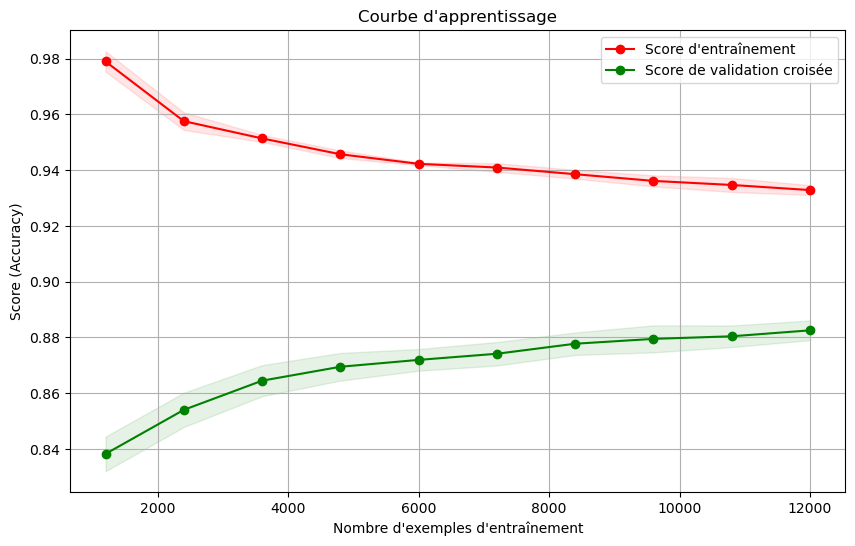

In [43]:
# --- Fonction courbe d'apprentissage (Learning Curve) ---

train_sizes, train_scores, val_scores = learning_curve(
    best_model,  # Utilisez le MEILLEUR modèle
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calcul des moyennes et écarts-types
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Affichage de la courbe
plt.figure(figsize=(10, 6))
plt.title("Courbe d'apprentissage")
plt.xlabel("Nombre d'exemples d'entraînement")
plt.ylabel("Score (Accuracy)")

# Courbe d'entraînement
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")

# Courbe de validation
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation croisée")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.grid()
plt.show()


In [21]:

# --- Évaluation FINALE sur l'ensemble de TEST ---
y_pred = best_model.predict(X_test)
print("\nPerformance sur l'ensemble de TEST:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Performance sur l'ensemble de TEST:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       609
           1       0.85      0.86      0.85       641

    accuracy                           0.85      1250
   macro avg       0.85      0.85      0.85      1250
weighted avg       0.85      0.85      0.85      1250

[[511  98]
 [ 91 550]]


9. Ethical Considerations and Explainability:

    Goal: Discuss the ethics in using and deploying your AI-based solution by investigating and implementing suitable explainability methods.
    
    Task: Understanding how a machine learning model makes predictions is crucial for ensuring transparency, fairness, and accountability in AI deployment. One of the widely used techniques for model explainability is SHAP (SHapley Additive exPlanations), which helps determine how much each feature (word) contributes to a prediction.
    In this task, you will use SHAP to analyze the impact of individual words on sentiment classification. This will allow you to visualize which words increase or decrease the probability of a positive or negative sentiment prediction. Additionally, discuss key aspects such as potential biases in the model, fairness in outcomes, and accountability in AI decision-making. You can find more information here: https://shap.readthedocs.io/en/latest/generated/shap.Explanation.html

In [ ]:
# TASK 9: Ethical Considerations & Explainability

# Show SHAP summary plot with proper feature names


10. Deployment Considerations for Embedded Systems:

    Goal: Optimize and convert the trained logistic regression model for deployment on embedded systems like Arduino
    
    Task: To deploy the trained logistic regression model on a resource-constrained embedded system like an Arduino, we must optimize and convert the model into a format suitable for execution in an environment with limited memory and processing power. Since embedded systems do not support direct execution of machine learning models trained in Python, we extract the model’s learned parameters—namely, the weights and bias—after training. These parameters are then quantized to fixed-point integers to eliminate the need for floating-point calculations, which are inefficient on microcontrollers.
    Once quantization is applied, we generate a C++ .h header file containing the model’s coefficients and bias, formatted in a way that allows direct use within an Arduino sketch. The final model is optimized to perform inference using integer arithmetic, making it both lightweight and efficient for deployment on microcontrollers. You can find more information here: https://medium.com/@thommaskevin/tinyml-binomial-logistic-regression-0fdbf00e6765

In [ ]:
# TASK 10: Deployment Considerations (Model Quantization & Export for Arduino)
# Extract weights and bias from the trained logistic regression model

# Apply quantization (convert to fixed-point representation)

# Generate C++ header file for Arduino

# Save the header file
